# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

Reference: https://www.tensorflow.org/tutorials



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import sys, os


In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50 as pretrained, preprocess_input

In [0]:
url = 'https://i.pinimg.com/564x/19/75/da/1975da067708bb057acd2e108b8210e4.jpg'

In [0]:
import IPython.display as display
from PIL import Image
import PIL

In [0]:
base_model = pretrained(include_top=False, weights='imagenet')

In [33]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
#layers = [base_model.get_layer(name).output for name in names] 
layers = [base_model.get_layer('conv2_block1_1_conv').output]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [35]:
print(layers)

[<tf.Tensor 'conv2_block1_1_conv_1/Identity:0' shape=(None, None, None, 64) dtype=float32>]


In [0]:
def get_image(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)


In [0]:
sample_image = get_image(url, 500)

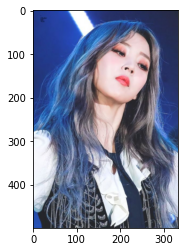

In [38]:
plt.imshow(sample_image)

In [0]:
sample_image = tf.Variable(preprocess_input(sample_image))

In [40]:
sample_image.shape

TensorShape([500, 333, 3])

In [0]:
img_batch = tf.expand_dims(sample_image, axis=0)

In [42]:
img_batch.shape

TensorShape([1, 500, 333, 3])

In [0]:
activations = dream_model.predict(img_batch)

In [0]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)



In [45]:
loss = calc_loss(sample_image, dream_model)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=-1.4091321>

In [0]:
def deprocess(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)

In [0]:
# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))
  #plt.imshow(img)


In [0]:
def deepdream(model,img, run_steps,step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(run_steps):
      with tf.GradientTape() as tape:
        # This needs gradients relative to `img`
        # `GradientTape` only watches `tf.Variable`s by default
        tape.watch(img)
        loss = calc_loss(img, model)

      # Calculate the gradient of the loss with respect to the pixels of the input image.
      gradients = tape.gradient(loss, img)

      # Normalize the gradients.
      gradients /= tf.math.reduce_std(gradients) + 1e-8 
      
      # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
      # You can update the image by directly adding the gradients
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [0]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(dream_model, img, run_steps, tf.constant(step_size))
    #display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  #display.clear_output(wait=True)
  show(result)

  return result

Tracing


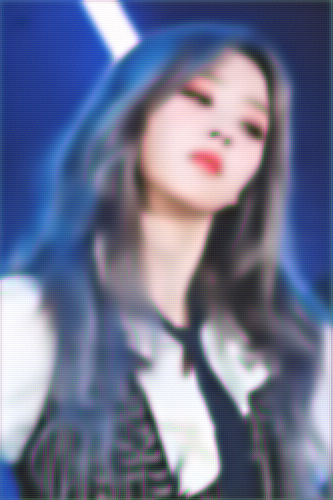

Step 100, loss -1.0278410911560059
Tracing


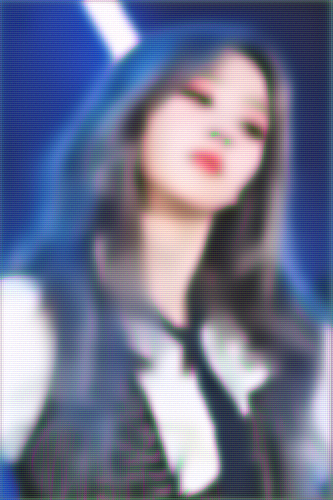

Step 200, loss -1.0276697874069214
Tracing


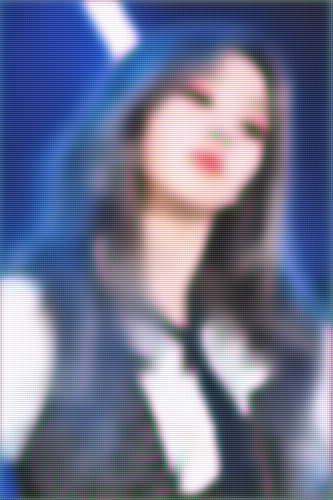

Step 300, loss -1.027565836906433


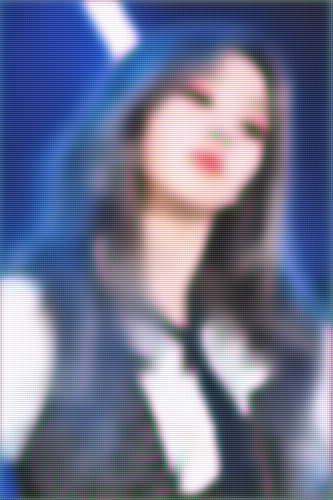

In [50]:
sample_image = get_image(url, 500)
dream_img = run_deep_dream_simple(img=sample_image, steps=300, step_size=0.01)


Tracing


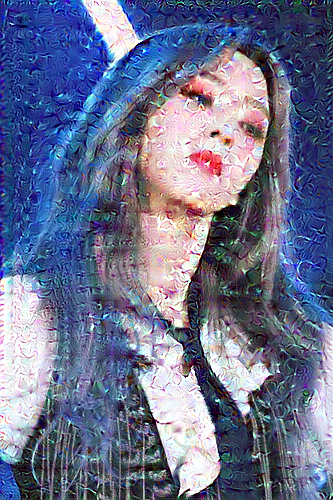

Step 100, loss 0.09132135659456253
Tracing


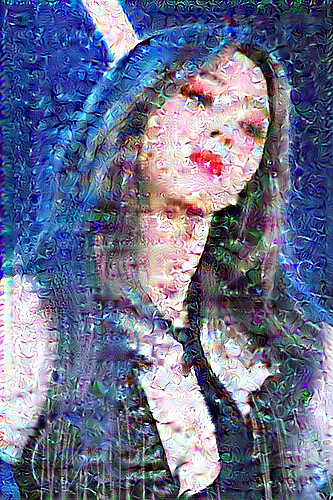

Step 200, loss 0.12866954505443573
Tracing


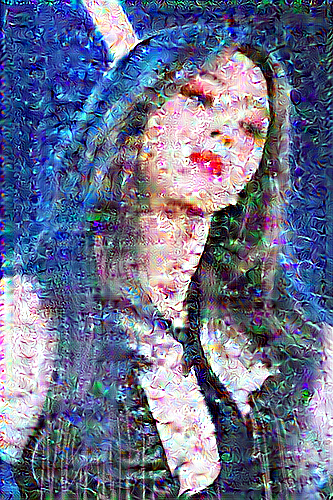

Step 300, loss 0.14866961538791656
Tracing


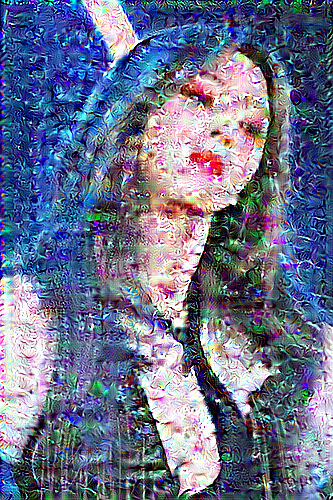

Step 400, loss 0.16324585676193237
Tracing


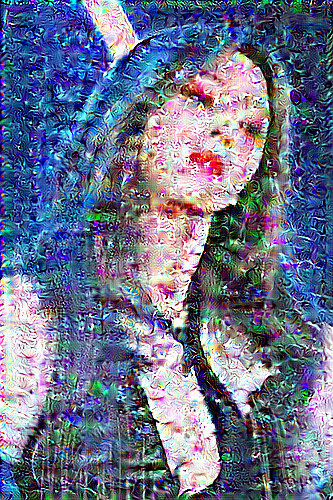

Step 500, loss 0.17334213852882385
Tracing


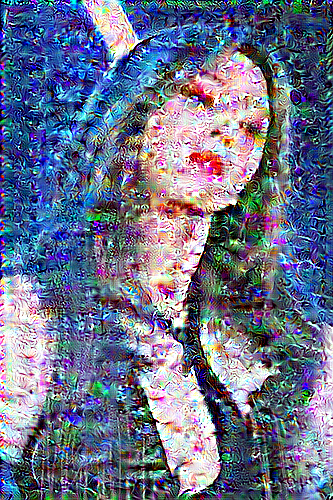

Step 600, loss 0.1818973422050476
Tracing


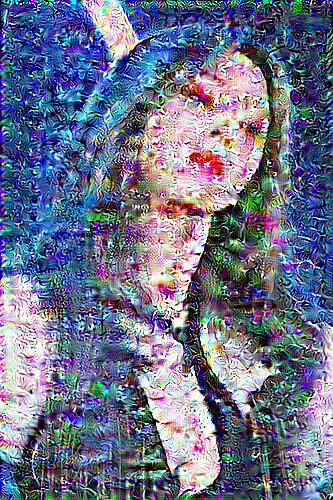

Step 700, loss 0.18963700532913208
Tracing


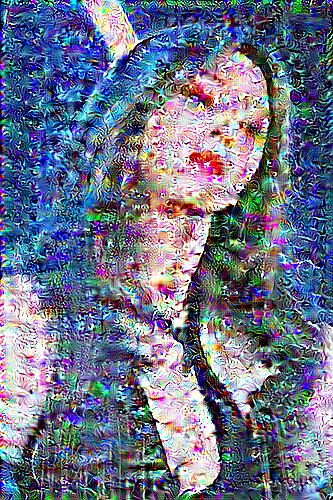

Step 800, loss 0.19528622925281525
Tracing


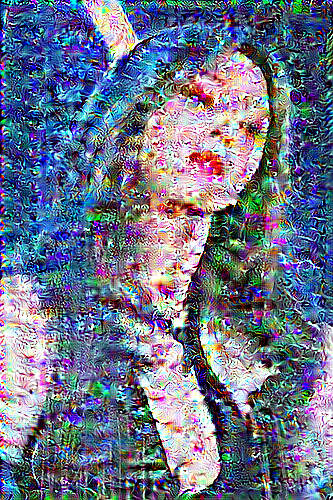

Step 900, loss 0.20058436691761017
Tracing


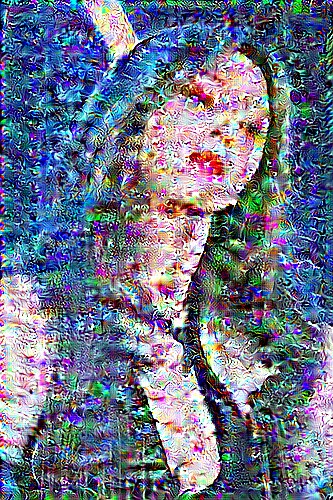

Step 1000, loss 0.20517639815807343


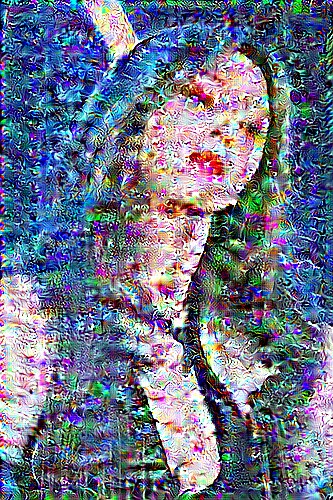

In [56]:
layers = [base_model.get_layer('conv5_block3_2_conv').output]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_img = run_deep_dream_simple(img=sample_image, steps=1000, step_size=0.01)